In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import plotly
import chart_studio.plotly as py
import plotly.express as px
import cufflinks as cf
cf.go_offline()

import lightgbm as lgb

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from pathlib import Path
import time

import datetime as datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Load dataset

In [2]:
%%time
root = Path(r'D:\Temp\20200612\GEPIII_dataset')

train_df = pd.read_feather(root/'train.feather')
train_df_pivot = pd.read_pickle(root/'train_df_pivot.pickle.gz')
test_df = pd.read_feather(root/'test.feather')
weather_train_df = pd.read_feather(root/'weather_train.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')
new_building_meta_df = pd.read_pickle(root/'new_building_meta_df.pickle')

df_solution = pd.read_csv(root/'solution.csv')

df_holiday = pd.read_pickle(root/'df_holiday.pickle')

Wall time: 13 s


In [3]:
test_df['meter_reading'] = df_solution['meter_reading']

In [4]:
path_trends = r'C:\Users\patri\hourlyHistoricalData_pytrends\raw data'

file = 'df_daily_merged.pickle'
df_daily_merged = pd.read_pickle(os.path.join(path_trends, file))
df_trends_daily = df_daily_merged.pivot_table(columns=['geo_id', 'keyword'], index='date', values='trend')
df_trends_daily.columns = ['_'.join(col) for col in df_trends_daily.columns.values]

In [5]:
df_holiday_encode = df_holiday[~df_holiday['Type'].str.contains('observance',case=False)].copy()
df_holiday_encode = df_holiday_encode[df_holiday_encode['Country']=='US']
df_holiday_encode = df_holiday_encode.drop('Country', axis=1)
df_holiday_encode = df_holiday_encode.drop_duplicates(subset=['Date'])
df_holiday_encode = df_holiday_encode.set_index('Date').asfreq('D')
df_holiday_encode.loc[df_holiday_encode.index.weekday>=5, 'Name'] = 'weekend'
df_holiday_encode.loc[df_holiday_encode.index.weekday>=5, 'Type'] = 'weekend'

df_holiday_encode[['holiday_Name', 'holiday_Type']] = df_holiday_encode[['Name', 'Type']].astype('str').apply(LabelEncoder().fit_transform)
df_holiday_encode = df_holiday_encode.drop(['Name', 'Type'],axis=1)
df_holiday_encode = df_holiday_encode.reset_index().rename(columns={'Date':'date'})
df_holiday_encode

,date,holiday_Name,holiday_Type
0,2016-01-01,77,2
1,2016-01-02,125,13
2,2016-01-03,125,13
3,2016-01-04,124,12
4,2016-01-05,124,12
...,...,...,...
1822,2020-12-27,125,13
1823,2020-12-28,124,12
1824,2020-12-29,124,12
1825,2020-12-30,124,12


Take **site13_bldg1083_meter0** as an example

<AxesSubplot:xlabel='timestamp'>

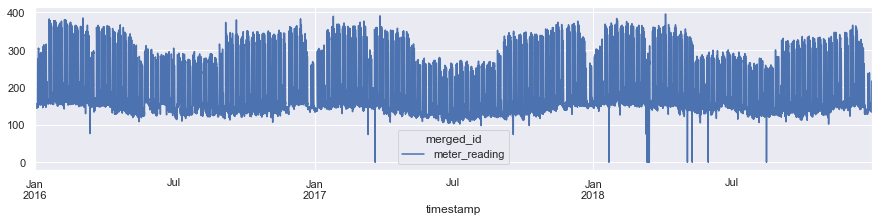

In [6]:
df_powerMeter = train_df_pivot[['site13_bldg1083_meter0']].copy()
df_powerMeter_test = test_df[(test_df['building_id']==1083)&(test_df['meter']==0)].set_index('timestamp').sort_index()[['meter_reading']]

df_powerMeter = df_powerMeter.rename(columns={'site13_bldg1083_meter0':'meter_reading'})
df_powerMeter = df_powerMeter.append(df_powerMeter_test)

df_powerMeter.plot(figsize=(15,3))

<AxesSubplot:xlabel='timestamp'>

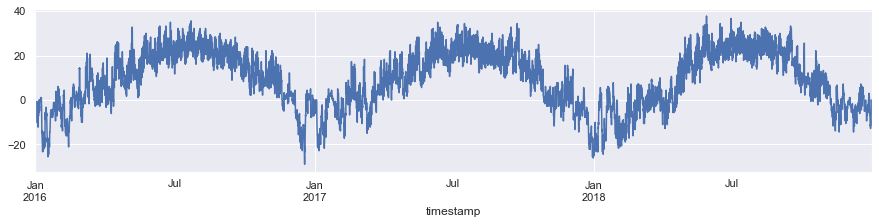

In [7]:
weather_train_df = pd.read_feather(root/'weather_train.feather')
weather_test_df = pd.read_feather(root/'weather_test.feather')
# weather_train_df[weather_train_df['site_id']==13].set_index('timestamp')

df_weather = pd.concat([weather_train_df, weather_test_df], axis=0, ignore_index=True)
df_weather = df_weather[df_weather['site_id']==13].set_index('timestamp')
df_weather = df_weather.resample('H').interpolate()
df_weather['air_temperature'].plot(figsize=(15,3))

<AxesSubplot:xlabel='date'>

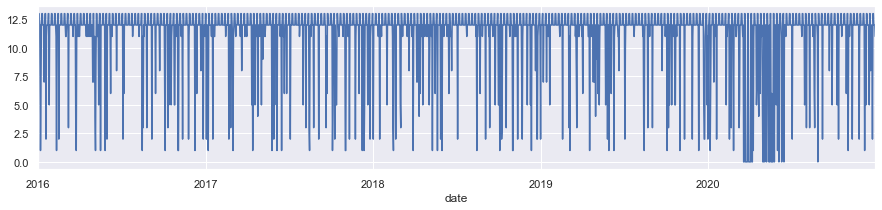

In [8]:
df_holiday_encode.set_index('date').asfreq('D').fillna(0)['holiday_Type'].plot(figsize=(15,3))

# Build regression model

### Model #1: forecasting model with only time-series features

In [9]:
# Prepare data for modeling
df_temp = df_powerMeter.reset_index().copy()
df_temp = df_temp.dropna()

# Add timestamp features
df_temp['weekday'] = df_temp['timestamp'].dt.weekday
df_temp['hour'] = df_temp['timestamp'].dt.hour
df_temp['date'] =pd.to_datetime(df_temp['timestamp'].dt.date)

df_temp = df_temp.set_index('timestamp').drop(['date'],axis=1)

df_temp

merged_id,meter_reading,weekday,hour
timestamp,,,
2016-01-01 00:00:00,154.380005,4,0
2016-01-01 01:00:00,154.380005,4,1
2016-01-01 02:00:00,152.578003,4,2
2016-01-01 03:00:00,148.858002,4,3
2016-01-01 04:00:00,151.748993,4,4
...,...,...,...
2018-12-31 19:00:00,180.000000,0,19
2018-12-31 20:00:00,176.000000,0,20
2018-12-31 21:00:00,165.000000,0,21


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning:

FixedFormatter should only be used together with FixedLocator



<AxesSubplot:xlabel='weekday,hour'>

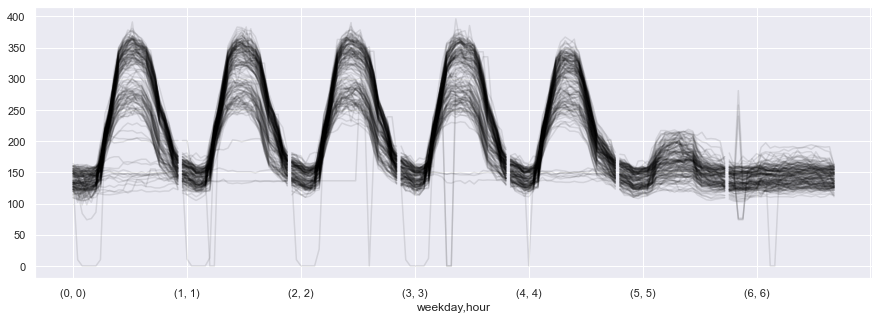

In [10]:
# Weekly profiles of building energy
df_plot = df_temp.copy()
df_plot['date'] = pd.to_datetime(df_plot.index.date)
df_plot.pivot_table(columns=['weekday','hour'], index='date', values='meter_reading').T.plot(figsize=(15,5),color='black',alpha=0.1,legend=False)

MAPE: inf
NMBE: -1.98
CVRSME: 15.42
R SQUARED: 0.81


<AxesSubplot:xlabel='timestamp'>

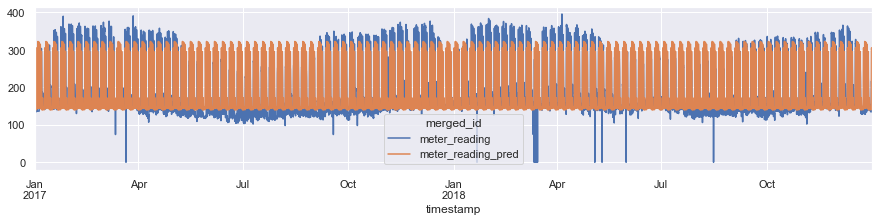

In [11]:
traindata = df_temp.loc['2016'].copy()
testdata = df_temp.loc['2017':'2018'].copy()

train_labels = traindata['meter_reading']
test_labels = testdata['meter_reading']

train_features = traindata.drop('meter_reading', axis=1)
test_features = testdata.drop('meter_reading', axis=1) 

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(train_features, train_labels)

testdata['meter_reading_pred'] = LGB_model.predict(test_features)

df_temp.loc[testdata.index, 'meter_reading_pred'] = testdata['meter_reading_pred']

# Calculate the absolute errors
errors = abs(testdata['meter_reading_pred'] - test_labels)

# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(testdata.dropna()['meter_reading'] - testdata.dropna()['meter_reading_pred']) / (testdata.dropna()['meter_reading'].count() * np.mean(testdata.dropna()['meter_reading'])))
CVRSME = 100 * ((sum((testdata.dropna()['meter_reading'] - testdata.dropna()['meter_reading_pred'])**2) / (testdata.dropna()['meter_reading'].count()-1))**(0.5)) / np.mean(testdata.dropna()['meter_reading'])
RSQUARED = r2_score(testdata.dropna()['meter_reading'], testdata.dropna()['meter_reading_pred'])

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

testdata[['meter_reading', 'meter_reading_pred']].plot(figsize=(15,3))

### Model #2: forecasting model with time-series and weather features

In [12]:
# Prepare data for modeling
df_temp = df_powerMeter.reset_index().copy()
df_temp = df_temp.dropna()

# Add timestamp features
df_temp['weekday'] = df_temp['timestamp'].dt.weekday
df_temp['hour'] = df_temp['timestamp'].dt.hour
df_temp['date'] =pd.to_datetime(df_temp['timestamp'].dt.date)

# Add weather features
df_temp = df_temp.merge(df_weather['air_temperature'].reset_index(), on='timestamp')

df_temp = df_temp.set_index('timestamp').drop(['date'],axis=1)

df_temp

,meter_reading,weekday,hour,air_temperature
timestamp,,,,
2016-01-01 00:00:00,154.380005,4,0,-8.3
2016-01-01 01:00:00,154.380005,4,1,-8.3
2016-01-01 02:00:00,152.578003,4,2,-7.8
2016-01-01 03:00:00,148.858002,4,3,-7.8
2016-01-01 04:00:00,151.748993,4,4,-7.2
...,...,...,...,...
2018-12-31 19:00:00,180.000000,0,19,-2.8
2018-12-31 20:00:00,176.000000,0,20,-3.3
2018-12-31 21:00:00,165.000000,0,21,-3.9


MAPE: inf
NMBE: -2.91
CVRSME: 14.16
R SQUARED: 0.84


<AxesSubplot:xlabel='timestamp'>

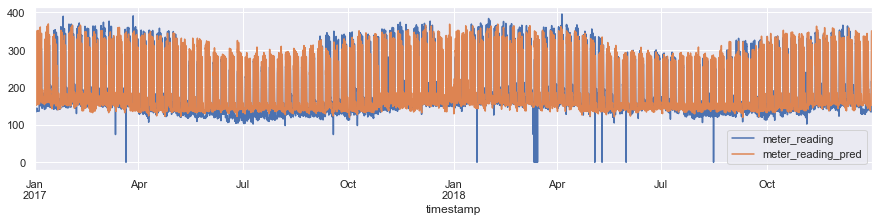

In [13]:
traindata = df_temp.loc['2016'].copy()
testdata = df_temp.loc['2017':'2018'].copy()

train_labels = traindata['meter_reading']
test_labels = testdata['meter_reading']

train_features = traindata.drop('meter_reading', axis=1)
test_features = testdata.drop('meter_reading', axis=1) 

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(train_features, train_labels)

testdata['meter_reading_pred'] = LGB_model.predict(test_features)

df_temp.loc[testdata.index, 'meter_reading_pred'] = testdata['meter_reading_pred']

# Calculate the absolute errors
errors = abs(testdata['meter_reading_pred'] - test_labels)

# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(testdata.dropna()['meter_reading'] - testdata.dropna()['meter_reading_pred']) / (testdata.dropna()['meter_reading'].count() * np.mean(testdata.dropna()['meter_reading'])))
CVRSME = 100 * ((sum((testdata.dropna()['meter_reading'] - testdata.dropna()['meter_reading_pred'])**2) / (testdata.dropna()['meter_reading'].count()-1))**(0.5)) / np.mean(testdata.dropna()['meter_reading'])
RSQUARED = r2_score(testdata.dropna()['meter_reading'], testdata.dropna()['meter_reading_pred'])

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

testdata[['meter_reading', 'meter_reading_pred']].plot(figsize=(15,3))

timestamp
2017-01-02    108.265930
2017-01-03    111.210045
2017-01-04     68.268682
2017-01-16     91.904752
2017-03-17     52.169176
2017-05-29     99.835977
2017-09-04     83.806964
2017-11-23     89.748881
2017-11-24     71.304673
2017-12-25     78.637521
2017-12-26     82.529299
2017-12-28     57.576790
2018-01-15     76.257144
2018-03-12     71.475214
2018-03-13     64.413993
2018-03-14     62.224048
2018-03-15     53.632395
2018-03-16     70.088292
2018-11-22     89.191675
2018-11-23     72.771395
2018-12-24     98.061197
2018-12-25    106.844495
2018-12-26     51.392508
2018-12-31     65.893425
dtype: float64

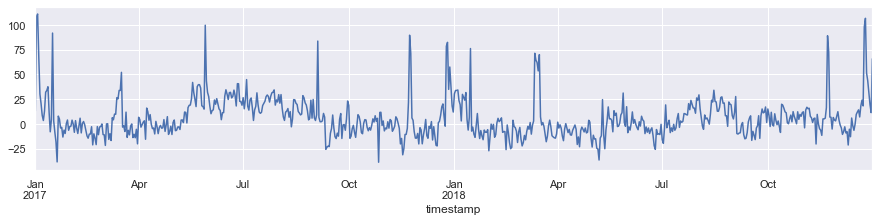

In [14]:
(testdata['meter_reading_pred']-testdata['meter_reading']).resample('D').mean().plot(figsize=(15,3))
df_error = (testdata['meter_reading_pred']-testdata['meter_reading']).resample('D').mean().abs()
df_error = df_error[df_error>50]
df_error

### Model #3: forecasting model with time-series, weather features, and holidays

In [15]:
# Prepare data for modeling
df_temp = df_powerMeter.reset_index().copy()
df_temp = df_temp.dropna()

# Add timestamp features
df_temp['weekday'] = df_temp['timestamp'].dt.weekday
df_temp['hour'] = df_temp['timestamp'].dt.hour
df_temp['date'] =pd.to_datetime(df_temp['timestamp'].dt.date)

# Add weather features
df_temp = df_temp.merge(df_weather['air_temperature'].reset_index(), on='timestamp')

# Add holiday features
df_temp = df_temp.merge(df_holiday_encode, on='date')

df_temp = df_temp.set_index('timestamp').drop(['date'],axis=1)

df_temp

,meter_reading,weekday,hour,air_temperature,holiday_Name,holiday_Type
timestamp,,,,,,
2016-01-01 00:00:00,154.380005,4,0,-8.3,77,2
2016-01-01 01:00:00,154.380005,4,1,-8.3,77,2
2016-01-01 02:00:00,152.578003,4,2,-7.8,77,2
2016-01-01 03:00:00,148.858002,4,3,-7.8,77,2
2016-01-01 04:00:00,151.748993,4,4,-7.2,77,2
...,...,...,...,...,...,...
2018-12-31 19:00:00,180.000000,0,19,-2.8,79,11
2018-12-31 20:00:00,176.000000,0,20,-3.3,79,11
2018-12-31 21:00:00,165.000000,0,21,-3.9,79,11


MAPE: inf
NMBE: -2.35
CVRSME: 12.4
R SQUARED: 0.88


<AxesSubplot:xlabel='timestamp'>

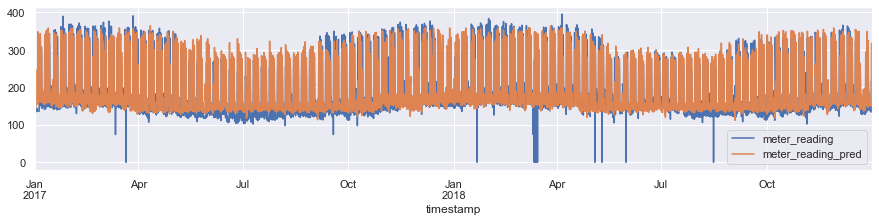

In [16]:
traindata = df_temp.loc['2016'].copy()
testdata = df_temp.loc['2017':'2018'].copy()

train_labels = traindata['meter_reading']
test_labels = testdata['meter_reading']

train_features = traindata.drop('meter_reading', axis=1)
test_features = testdata.drop('meter_reading', axis=1) 

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(train_features, train_labels)

testdata['meter_reading_pred'] = LGB_model.predict(test_features)

df_temp.loc[testdata.index, 'meter_reading_pred'] = testdata['meter_reading_pred']

# Calculate the absolute errors
errors = abs(testdata['meter_reading_pred'] - test_labels)

# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(testdata.dropna()['meter_reading'] - testdata.dropna()['meter_reading_pred']) / (testdata.dropna()['meter_reading'].count() * np.mean(testdata.dropna()['meter_reading'])))
CVRSME = 100 * ((sum((testdata.dropna()['meter_reading'] - testdata.dropna()['meter_reading_pred'])**2) / (testdata.dropna()['meter_reading'].count()-1))**(0.5)) / np.mean(testdata.dropna()['meter_reading'])
RSQUARED = r2_score(testdata.dropna()['meter_reading'], testdata.dropna()['meter_reading_pred'])

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

testdata[['meter_reading', 'meter_reading_pred']].plot(figsize=(15,3))

timestamp
2017-01-02     57.301332
2017-01-03    109.704731
2017-01-04     67.691514
2017-03-17     52.254036
2017-10-09     56.653510
2017-12-26     75.907553
2017-12-28     52.744407
2018-03-12     76.953484
2018-03-13     65.061171
2018-03-14     67.874185
2018-03-15     62.177677
2018-03-16     58.370960
2018-07-04     52.934979
2018-10-08     67.484677
2018-12-27     58.524415
2018-12-31     56.832338
dtype: float64

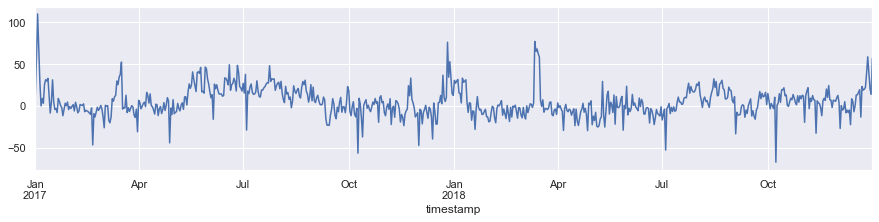

In [17]:
(testdata['meter_reading_pred']-testdata['meter_reading']).resample('D').mean().plot(figsize=(15,3))
df_error = (testdata['meter_reading_pred']-testdata['meter_reading']).resample('D').mean().abs()
df_error = df_error[df_error>50]
df_error

### Model #4: forecasting model with time-series, weather features, and google trends

In [18]:
# Prepare data for modeling
df_temp = df_powerMeter.reset_index().copy()
df_temp = df_temp.dropna()

# Add timestamp features
df_temp['weekday'] = df_temp['timestamp'].dt.weekday
df_temp['hour'] = df_temp['timestamp'].dt.hour
df_temp['date'] =pd.to_datetime(df_temp['timestamp'].dt.date)

# Add weather features
df_temp = df_temp.merge(df_weather['air_temperature'].reset_index(), on='timestamp')

# Add holiday features
df_temp = df_temp.merge(df_trends_daily[['US_Microsoft Office','US_Google Docs','US_Adobe']].reset_index(), on='date')

df_temp = df_temp.set_index('timestamp').drop(['date'],axis=1)

df_temp

,meter_reading,weekday,hour,air_temperature,US_Microsoft Office,US_Google Docs,US_Adobe
timestamp,,,,,,,
2016-01-03 00:00:00,148.389999,6,0,-2.8,32.68,8.74,56.96
2016-01-03 01:00:00,146.737000,6,1,-3.3,32.68,8.74,56.96
2016-01-03 02:00:00,147.014008,6,2,-4.4,32.68,8.74,56.96
2016-01-03 03:00:00,148.839005,6,3,-3.3,32.68,8.74,56.96
2016-01-03 04:00:00,148.330002,6,4,-3.9,32.68,8.74,56.96
...,...,...,...,...,...,...,...
2018-12-31 19:00:00,180.000000,0,19,-2.8,25.76,2.43,30.50
2018-12-31 20:00:00,176.000000,0,20,-3.3,25.76,2.43,30.50
2018-12-31 21:00:00,165.000000,0,21,-3.9,25.76,2.43,30.50


MAPE: inf
NMBE: -3.25
CVRSME: 11.53
R SQUARED: 0.89


<AxesSubplot:xlabel='timestamp'>

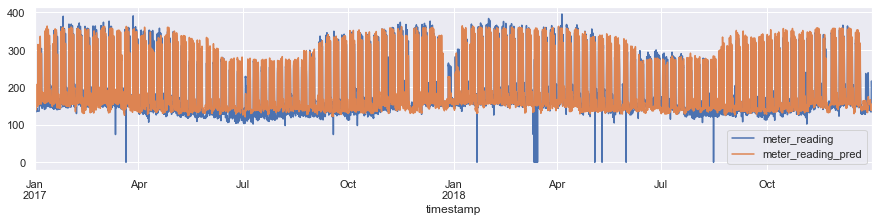

In [19]:
traindata = df_temp.loc['2016'].copy()
testdata = df_temp.loc['2017':'2018'].copy()

train_labels = traindata['meter_reading']
test_labels = testdata['meter_reading']

train_features = traindata.drop('meter_reading', axis=1)
test_features = testdata.drop('meter_reading', axis=1) 

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(train_features, train_labels)

testdata['meter_reading_pred'] = LGB_model.predict(test_features)

df_temp.loc[testdata.index, 'meter_reading_pred'] = testdata['meter_reading_pred']

# Calculate the absolute errors
errors = abs(testdata['meter_reading_pred'] - test_labels)

# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(testdata.dropna()['meter_reading'] - testdata.dropna()['meter_reading_pred']) / (testdata.dropna()['meter_reading'].count() * np.mean(testdata.dropna()['meter_reading'])))
CVRSME = 100 * ((sum((testdata.dropna()['meter_reading'] - testdata.dropna()['meter_reading_pred'])**2) / (testdata.dropna()['meter_reading'].count()-1))**(0.5)) / np.mean(testdata.dropna()['meter_reading'])
RSQUARED = r2_score(testdata.dropna()['meter_reading'], testdata.dropna()['meter_reading_pred'])

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

testdata[['meter_reading', 'meter_reading_pred']].plot(figsize=(15,3))

timestamp
2017-01-03    88.608653
2017-01-04    56.624080
2017-01-16    81.182595
2017-03-17    56.784828
2017-05-30    51.298751
2018-01-15    60.210449
2018-03-12    78.154299
2018-03-13    71.157689
2018-03-14    76.187224
2018-03-15    67.133620
2018-03-16    76.736919
2018-07-04    56.443147
dtype: float64

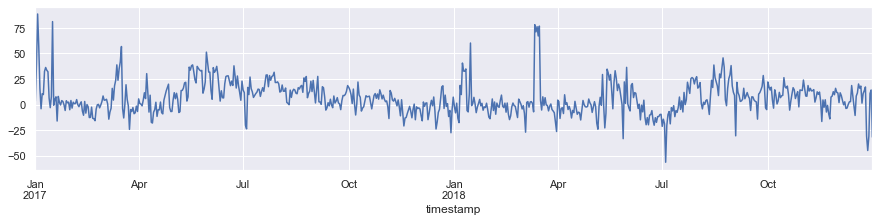

In [20]:
(testdata['meter_reading_pred']-testdata['meter_reading']).resample('D').mean().plot(figsize=(15,3))
df_error = (testdata['meter_reading_pred']-testdata['meter_reading']).resample('D').mean().abs()
df_error = df_error[df_error>50]
df_error